In [1]:
# DataFrame
import pandas as pd

# Matplot
import matplotlib.pyplot as plt
%matplotlib inline

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model
from keras.layers import Input, Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM, concatenate
from keras.layers import GaussianDropout, GaussianNoise
from keras.layers import GRU, Bidirectional, TimeDistributed
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# nltk
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

# Word2vec
import gensim

# Utility
import os
import re
import numpy as np
from collections import Counter
import logging
import time
import pickle
import itertools

# Set log
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

Using TensorFlow backend.


In [2]:
# DATASET
DATASET_COLUMNS = ["target", "text"]
DATASET_ENCODING = "ISO-8859-1"
TRAIN_SIZE = 0.8

# TEXT CLENAING
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S"

# WORD2VEC
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 6
W2V_SIZE = 100

SEQUENCE_LENGTH = 200

MAXLEN = 100
MAX_SENTENCES = 15
MAX_WORDS = 20000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2

# EXPORT
KERAS_MODEL = "model.h5"
WORD2VEC_MODEL = "model.w2v"
TOKENIZER_MODEL = "tokenizer.pkl"
ENCODER_MODEL = "encoder.pkl"

In [3]:
from keras import backend as K
from keras.engine.topology import Layer, InputSpec
from keras import initializers

# class defining the custom attention layer
class HierarchicalAttentionNetwork(Layer):
    def __init__(self, attention_dim):
        self.init = initializers.get('normal')
        self.supports_masking = True
        self.attention_dim = attention_dim
        super(HierarchicalAttentionNetwork, self).__init__()

    def build(self, input_shape):
        assert len(input_shape) == 3
        self.W = K.variable(self.init((input_shape[-1], self.attention_dim)))
        self.b = K.variable(self.init((self.attention_dim,)))
        self.u = K.variable(self.init((self.attention_dim, 1)))
        self.trainable_weights = [self.W, self.b, self.u]
        super(HierarchicalAttentionNetwork, self).build(input_shape)

    def compute_mask(self, inputs, mask=None):
        return None

    def call(self, x, mask=None):
        # size of x :[batch_size, sel_len, attention_dim]
        # size of u :[batch_size, attention_dim]
        # uit = tanh(xW+b)
        uit = K.tanh(K.bias_add(K.dot(x, self.W), self.b))

        ait = K.exp(K.squeeze(K.dot(uit, self.u), -1))

        if mask is not None:
            # Cast the mask to floatX to avoid float64 upcasting
            ait *= K.cast(mask, K.floatx())
        ait /= K.cast(K.sum(ait, axis=1, keepdims=True) + K.epsilon(), K.floatx())
        weighted_input = x * K.expand_dims(ait)
        output = K.sum(weighted_input, axis=1)

        return output

    def compute_output_shape(self, input_shape):
        return input_shape[0], input_shape[-1]

In [4]:
df_train = pd.read_csv("yelp2015/train.csv", encoding=DATASET_ENCODING , names=DATASET_COLUMNS)
df_test = pd.read_csv("yelp2015/test.csv", encoding=DATASET_ENCODING , names=DATASET_COLUMNS)

In [5]:
def preprocess(text):
    # Remove link,user and special characters
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
      tokens.append(token)
    return " ".join(tokens)

In [6]:
%%time
df_train.text = df_train.text.apply(lambda x: preprocess(x))
df_test.text = df_test.text.apply(lambda x: preprocess(x))

Wall time: 19.5 s


In [7]:
decode_map = {1: 0, 2: 1, 3: 2, 4: 3, 5: 4}
def decode_sentiment(label):
    return decode_map[int(label)]

In [8]:
%%time
df_train.target = df_train.target.apply(lambda x: decode_sentiment(x))
df_test.target = df_test.target.apply(lambda x: decode_sentiment(x))

Wall time: 415 ms


In [9]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\covin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [10]:
%%time
documents = [_text.split() for _text in df_train.text]

Wall time: 10.2 s


In [11]:
w2v_model = gensim.models.word2vec.Word2Vec(size=W2V_SIZE, 
                                            window=W2V_WINDOW, 
                                            min_count=W2V_MIN_COUNT, 
                                            workers=8)

In [12]:
w2v_model.build_vocab(documents)

2020-05-03 09:28:21,573 : INFO : collecting all words and their counts
2020-05-03 09:28:21,574 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2020-05-03 09:28:21,861 : INFO : PROGRESS: at sentence #10000, processed 1301608 words, keeping 73325 word types
2020-05-03 09:28:22,123 : INFO : PROGRESS: at sentence #20000, processed 2581717 words, keeping 119474 word types
2020-05-03 09:28:22,389 : INFO : PROGRESS: at sentence #30000, processed 3869673 words, keeping 157572 word types
2020-05-03 09:28:22,642 : INFO : PROGRESS: at sentence #40000, processed 5133261 words, keeping 188307 word types
2020-05-03 09:28:22,905 : INFO : PROGRESS: at sentence #50000, processed 6392410 words, keeping 217321 word types
2020-05-03 09:28:23,143 : INFO : PROGRESS: at sentence #60000, processed 7635534 words, keeping 242870 word types
2020-05-03 09:28:23,401 : INFO : PROGRESS: at sentence #70000, processed 8936557 words, keeping 272165 word types
2020-05-03 09:28:23,655 : INFO : 

In [13]:
words = w2v_model.wv.vocab.keys()
vocab_size = len(words)
print("Vocab size", vocab_size)

Vocab size 152070


In [14]:
%%time
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

2020-05-03 09:29:12,348 : INFO : training model with 8 workers on 152070 vocabulary and 100 features, using sg=0 hs=0 sample=0.001 negative=5 window=7
2020-05-03 09:29:13,361 : INFO : EPOCH 1 - PROGRESS: at 2.27% examples, 1391887 words/s, in_qsize 13, out_qsize 2
2020-05-03 09:29:14,370 : INFO : EPOCH 1 - PROGRESS: at 4.56% examples, 1411473 words/s, in_qsize 12, out_qsize 3
2020-05-03 09:29:15,380 : INFO : EPOCH 1 - PROGRESS: at 6.89% examples, 1413038 words/s, in_qsize 14, out_qsize 1
2020-05-03 09:29:16,391 : INFO : EPOCH 1 - PROGRESS: at 9.31% examples, 1421456 words/s, in_qsize 15, out_qsize 0
2020-05-03 09:29:17,398 : INFO : EPOCH 1 - PROGRESS: at 11.59% examples, 1429233 words/s, in_qsize 14, out_qsize 1
2020-05-03 09:29:18,411 : INFO : EPOCH 1 - PROGRESS: at 13.96% examples, 1426166 words/s, in_qsize 12, out_qsize 3
2020-05-03 09:29:19,415 : INFO : EPOCH 1 - PROGRESS: at 16.28% examples, 1427750 words/s, in_qsize 14, out_qsize 1
2020-05-03 09:29:20,431 : INFO : EPOCH 1 - PROGR

Wall time: 24min 17s


(2078567380, 2789158208)

In [15]:
from nltk import tokenize

reviews = []
labels = []
texts = []

for idx, _ in df_train.iterrows():
    text = df_train.text[idx]
    texts.append(text)
    sentences = tokenize.sent_tokenize(text)
    reviews.append(sentences)
    labels.append(df_train.target[idx])

TRAIN_SIZE = len(texts)

for idx, _ in df_test.iterrows():
    text = df_test.text[idx]
    texts.append(text)
    sentences = tokenize.sent_tokenize(text)
    reviews.append(sentences)
    labels.append(df_test.target[idx])

In [16]:
from keras.preprocessing.text import text_to_word_sequence

tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)

data = np.zeros((len(texts), MAX_SENTENCES, MAXLEN), dtype='int32')

for i, sentences in enumerate(reviews):
    for j, sent in enumerate(sentences):
        if j < MAX_SENTENCES:
            wordTokens = text_to_word_sequence(sent)
            k = 0
            for _, word in enumerate(wordTokens):
                if k < MAXLEN and tokenizer.word_index[word] < MAX_WORDS:
                    data[i, j, k] = tokenizer.word_index[word]
                    k = k + 1

word_index = tokenizer.word_index
print('Total %s unique tokens.' % len(word_index))

Total 274081 unique tokens.


In [17]:
from keras.utils.np_utils import to_categorical

labels = to_categorical(np.asarray(labels))
print('Shape of reviews (data) tensor:', data.shape)
print('Shape of sentiment (label) tensor:', labels.shape)

Shape of reviews (data) tensor: (700000, 15, 100)
Shape of sentiment (label) tensor: (700000, 5)


In [18]:
x_train = data[:TRAIN_SIZE]
y_train = labels[:TRAIN_SIZE]
x_test = data[TRAIN_SIZE:]
y_test = labels[TRAIN_SIZE:]

In [24]:
# building Hierachical Attention network
embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
for word, i in tokenizer.word_index.items():
  if word in w2v_model.wv:
    embedding_matrix[i] = w2v_model.wv[word]

embedding_layer = Embedding(len(word_index) + 1, EMBEDDING_DIM, weights=[embedding_matrix],
                            input_length=MAXLEN, trainable=True)

In [25]:
sentence_input = Input(shape=(MAXLEN,), dtype='int32')
embedded_sequences = embedding_layer(sentence_input)
lstm_word = Bidirectional(GRU(50, return_sequences=True))(embedded_sequences)
attn_word = HierarchicalAttentionNetwork(100)(lstm_word)
sentenceEncoder = Model(sentence_input, attn_word)

review_input = Input(shape=(MAX_SENTENCES, MAXLEN), dtype='int32')
review_encoder = TimeDistributed(sentenceEncoder)(review_input)
lstm_sentence = Bidirectional(GRU(50, return_sequences=True))(review_encoder)
attn_sentence = HierarchicalAttentionNetwork(100)(lstm_sentence)
preds = Dense(5, activation='softmax')(attn_sentence)
model = Model(review_input, preds)

tracking <tf.Variable 'hierarchical_attention_network_3/Variable:0' shape=(100, 100) dtype=float32> W
tracking <tf.Variable 'hierarchical_attention_network_3/Variable_1:0' shape=(100,) dtype=float32> b
tracking <tf.Variable 'hierarchical_attention_network_3/Variable_2:0' shape=(100, 1) dtype=float32> u
tracking <tf.Variable 'hierarchical_attention_network_4/Variable:0' shape=(100, 100) dtype=float32> W
tracking <tf.Variable 'hierarchical_attention_network_4/Variable_1:0' shape=(100,) dtype=float32> b
tracking <tf.Variable 'hierarchical_attention_network_4/Variable_2:0' shape=(100, 1) dtype=float32> u


In [26]:
from keras import optimizers
sgd = optimizers.SGD(lr=0.01, momentum=0.9, nesterov=False)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['acc'])
model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 15, 100)           0         
_________________________________________________________________
time_distributed_2 (TimeDist (None, 15, 100)           27463700  
_________________________________________________________________
bidirectional_4 (Bidirection (None, 15, 100)           45300     
_________________________________________________________________
hierarchical_attention_netwo (None, 100)               10200     
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 505       
Total params: 27,519,705
Trainable params: 27,519,705
Non-trainable params: 0
_________________________________________________________________


In [27]:
callbacks = [EarlyStopping(monitor='val_acc', patience=5, mode='max')]

In [28]:
print("model fitting - Hierachical attention network")
history = model.fit(x_train, y_train, validation_split=0.2, nb_epoch=10, batch_size=64, callbacks=callbacks)

model fitting - Hierachical attention network


C:\Users\covin\miniconda3\envs\tensorflow1\lib\site-packages\ipykernel_launcher.py:2: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 520000 samples, validate on 130000 samples
Epoch 1/10
520000/520000 [==============================] - 3366s 6ms/step - loss: 0.9434 - acc: 0.5846 - val_loss: 0.8022 - val_acc: 0.6547
Epoch 2/10
520000/520000 [==============================] - 3390s 7ms/step - loss: 0.8554 - acc: 0.6251 - val_loss: 0.7882 - val_acc: 0.6586
Epoch 3/10
520000/520000 [==============================] - 3397s 7ms/step - loss: 0.8330 - acc: 0.6346 - val_loss: 0.7841 - val_acc: 0.6603
Epoch 4/10
520000/520000 [==============================] - 3420s 7ms/step - loss: 0.8185 - acc: 0.6416 - val_loss: 0.7722 - val_acc: 0.6637
Epoch 5/10
520000/520000 [==============================] - 3449s 7ms/step - loss: 0.8076 - acc: 0.6458 - val_loss: 0.7760 - val_acc: 0.6654
Epoch 6/10
520000/520000 [==============================] - 3451s 7ms/step - loss: 0.7987 - acc: 0.6500 - val_loss: 0.7616 - val_acc: 0.6695
Epoch 7/10
520000/520000 [==============================] - 3453s 7ms/step - loss: 0.7911 - acc: 0.653

In [29]:
%%time
score = model.evaluate(x_test, y_test, batch_size=100)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

50000/50000 [==============================] - 95s 2ms/step

ACCURACY: 0.6438999772071838
LOSS: 0.8079796648025512
Wall time: 1min 35s


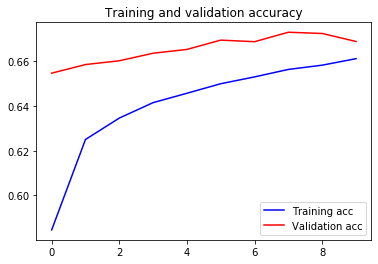

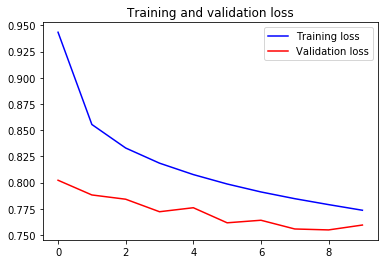

In [30]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

In [31]:
model.save("hatn_yelp2_modregex.h5")
w2v_model.save("w2v2_modregex_100.w2v")
pickle.dump(tokenizer, open("tokenizer2_modregex.pkl", "wb"), protocol=0)

2020-05-03 19:39:36,722 : INFO : saving Word2Vec object under w2v2_modregex_100.w2v, separately None
2020-05-03 19:39:36,725 : INFO : storing np array 'vectors' to w2v2_modregex_100.w2v.wv.vectors.npy
2020-05-03 19:39:36,867 : INFO : not storing attribute vectors_norm
2020-05-03 19:39:36,868 : INFO : storing np array 'syn1neg' to w2v2_modregex_100.w2v.trainables.syn1neg.npy
2020-05-03 19:39:37,011 : INFO : not storing attribute cum_table
2020-05-03 19:39:38,952 : INFO : saved w2v2_modregex_100.w2v


In [32]:
from nltk import tokenize
from keras.preprocessing.text import text_to_word_sequence

def predict_new_text(text, model, tokenizer):
    text = preprocess(text)
    texts = []
    reviews = []
    texts.append(text)
    sentences = tokenize.sent_tokenize(text)
    reviews.append(sentences)

    data = np.zeros((len(texts), MAX_SENTENCES, MAXLEN), dtype='int32')

    for i, sentences in enumerate(reviews):
        for j, sent in enumerate(sentences):
            if j < MAX_SENTENCES:
                wordTokens = text_to_word_sequence(sent)
                k = 0
                for _, word in enumerate(wordTokens):
                    if k < MAXLEN and tokenizer.word_index[word] < MAX_WORDS:
                        data[i, j, k] = tokenizer.word_index[word]
                        k = k + 1
                        
    ynew = model.predict(data)
    return ynew

In [33]:
text = "the restaurant we went yesterday was wonderful."
print(predict_new_text(text, model, tokenizer))
labels = [1, 2, 3, 4, 5]
print(labels[np.argmax(predict_new_text(text,model, tokenizer))])

[[0.01285873 0.01800156 0.07911148 0.28740832 0.60261995]]
5


In [34]:
text = "the restaurant we went yesterday was awful. The food was bad, the service was bad. Horrible place, disgusting food."
print(predict_new_text(text, model, tokenizer))
labels = [1, 2, 3, 4, 5]
print(labels[np.argmax(predict_new_text(text,model, tokenizer))])

[[9.7188032e-01 2.6860416e-02 1.2127325e-03 3.6880778e-05 9.5644900e-06]]
1


In [35]:
text = "The movie was good, funny and entertaining. Good cast and plot."
print(predict_new_text(text, model, tokenizer))
labels = [1, 2, 3, 4, 5]
print(labels[np.argmax(predict_new_text(text,model, tokenizer))])

[[0.00251016 0.02307176 0.3379341  0.48427352 0.15221052]]
4


In [36]:
text = "The movie was bad, boring and too slow paced. Bad cast and plot."
print(predict_new_text(text, model, tokenizer))
labels = [1, 2, 3, 4, 5]
print(labels[np.argmax(predict_new_text(text,model, tokenizer))])

[[0.33235657 0.5630523  0.0964011  0.00647789 0.00171209]]
2


In [37]:
from sklearn.metrics import confusion_matrix

y_pred = model.predict(x_test)

In [38]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    # print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Normalized confusion matrix


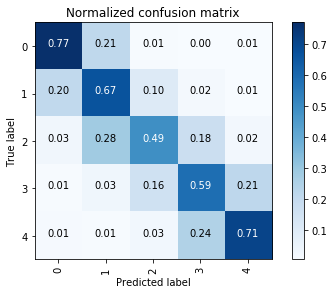

In [39]:
conf_matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
label_names = ['0', '1', '2', '3', '4']
plot_confusion_matrix(conf_matrix, classes=np.asarray(label_names), normalize=True,
                      title='Normalized confusion matrix')